In [34]:
# 通过多项式拟合交互式探索模型选择、过拟合和欠拟合概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l  # 导入深度学习库d2l

In [49]:
# # test 1
# true_w = np.zeros(10)
# true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
# true_w

array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [50]:
# # test 2
# features = np.random.normal(size=(10, 1))
# np.random.shuffle(features)
# features

array([[-0.33172762],
       [ 1.53573637],
       [-0.28927261],
       [ 1.72475231],
       [ 2.0743625 ],
       [-1.85515746],
       [ 0.40866167],
       [ 0.59022526],
       [ 0.77849455],
       [-0.34777311]])

In [51]:
# # test 3
# a = [[1, 2, 3], [4, 5], [6, 7, 8]]
# np.random.shuffle(a)
# a

[[6, 7, 8], [1, 2, 3], [4, 5]]

In [52]:
# # test 4
# # 对于每个原始特征值（features中的每个元素），计算它的0次幂到(max_degree-1)次幂
# features = [[1], [2], [3]]
# max_degree = 3
# poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# poly_features

array([[1, 1, 1],
       [1, 2, 4],
       [1, 3, 9]], dtype=int32)

In [53]:
# # test 5
# # arange 用于创建具有均匀间隔的数组
# """
# 主要区别：

# - `np.array` 主要用于将现有的数据（如列表）转换为数组。

# - `np.arange` 则用于生成一个数值序列（类似于等差数列），而不需要显式地写出所有元素。
# """
# a = np.array([0, 1, 2, 3, 4])
# b = np.arange(5)
# c = np.arange(0, 5, 1)
# a, b, c

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [61]:
# test 6
"""
scale 参数：

指定正态分布的标准差（standard deviation）

这里设为 0.1，表示数据点偏离均值的程度

较小的值（如 0.1）意味着噪声较小，较大的值（如 1.0）意味着噪声较大
"""
features = [[1], [2], [3]]  # 原始输入特征
max_degree = 5  # 多项式最大阶数
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 将原始特征扩展为多项式特征, 作为模拟多项式回归的输入
true_w = np.zeros(5)
true_w[0:3] = np.array([1, 2, 3])  # 真实权重
labels_origin = np.dot(poly_features, true_w)  # 通过点积生成真实标签
noise = np.random.normal(scale=0.1, size=labels_origin.shape) 
labels = labels_origin + noise  # 添加噪声
poly_features, true_w, labels_origin, noise, labels

(array([[ 1,  1,  1,  1,  1],
        [ 1,  2,  4,  8, 16],
        [ 1,  3,  9, 27, 81]], dtype=int32),
 array([1., 2., 3., 0., 0.]),
 array([ 6., 17., 34.]),
 array([ 0.07795884,  0.00578849, -0.2238136 ]),
 array([ 6.07795884, 17.00578849, 33.7761864 ]))

In [56]:
# 生成模拟数据
# 使用三阶多项式生成训练和测试数据的标签: y = 5 + 1.2(x1) - 3.4((x2)^2 / 2!) + 5.6((x3)^3 / 3!) + ε, 其中ε ~ N(0, 0.1^2)
max_degree = 20  # 多项式最大阶数
n_train, n_test = 100, 100  # 训练集和测试集大小

# 初始化真实权重（只有前4项非零）
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

# 原始输入特征，每个样本一个特征值（x）
features = np.random.normal(size=(n_train + n_test, 1))  # 生成随机特征
np.random.shuffle(features)  # 打乱特征顺序

# 创建多项式特征矩阵：每列是特征的幂次方
# np.power(a, b) 对 a 和 b 中对应位置的元素分别进行幂运算，要求两数组形状相同（或可广播）
# 对于每个原始特征值（features中的每个元素），计算它的0次幂到(max_degree-1)次幂
# 将每个原始特征扩展为多项式特征（从x^0到x^19，并除以阶乘），用于模拟多项式回归的输入
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # size=(200, 20)

# 应用阶乘归一化 (x^k / k!)
# 为了数值稳定性，避免高阶幂次带来的数值过大问题
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n+1) = n!

# 计算标签并添加高斯噪声
labels = np.dot(poly_features, true_w)  # 点积
labels += np.random.normal(scale=0.1, size=labels.shape)  # 添加噪声

In [57]:
# 看一下前2个样本
"""
这段代码的作用是将NumPy数组（或类似数组的对象）

转换为PyTorch张量（tensor），

并指定数据类型为32位浮点数（float32）
"""
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2, :], labels[:2]  # 打印前两个样本

(tensor([[-1.1617],
         [-0.0660]]),
 tensor([[ 1.0000e+00, -1.1617e+00,  6.7478e-01, -2.6130e-01,  7.5887e-02,
          -1.7632e-02,  3.4138e-03, -5.6654e-04,  8.2269e-05, -1.0619e-05,
           1.2336e-06, -1.3028e-07,  1.2613e-08, -1.1271e-09,  9.3523e-11,
          -7.2431e-12,  5.2589e-13, -3.5937e-14,  2.3194e-15, -1.4181e-16],
         [ 1.0000e+00, -6.5966e-02,  2.1758e-03, -4.7842e-05,  7.8899e-07,
          -1.0409e-08,  1.1444e-10, -1.0785e-12,  8.8930e-15, -6.5182e-17,
           4.2998e-19, -2.5786e-21,  1.4175e-23, -7.1927e-26,  3.3891e-28,
          -1.4904e-30,  6.1449e-33, -2.3845e-35,  8.7385e-38, -3.0339e-40]]),
 tensor([-0.1549,  5.0185]))

In [58]:
# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """ 评估给定数据集上模型的损失 """
    metric = d2l.Accumulator(2)  # 创建累加器：[总损失, 样本数]
    for X, y in data_iter:
        out = net(X)  # 前向传播
        y = y.reshape(out.shape)  # 调整标签形状匹配输出
        l = loss(out, y)  # 计算损失
        metric.add(l.sum(), l.numel())  # 累加损失和样本数
    return metric[0] / metric[1]  # 返回平均损失

In [59]:
# # test 7
# # 模拟训练数据：5个样本，每个样本3个特征
# train_features = np.array([
#     [1.2, 3.4, 5.6],  # 样本1
#     [0.9, 2.1, 4.3],  # 样本2
#     [1.8, 3.0, 6.1],  # 样本3
#     [0.5, 2.8, 5.0],  # 样本4
#     [1.0, 3.2, 5.5]   # 样本5
# ])

# print("数据维度:", train_features.shape)  # 输出: (5, 3)
# print("shape[-1]的值:", train_features.shape[-1])  # 输出: 3 → 特征数量

数据维度: (5, 3)
shape[-1]的值: 3


In [45]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()  # 使用均方误差损失
    input_shape = train_features.shape[-1]  # 输入特征维度

    """ 
    在Python中，数组的shape属性返回一个表示各维度大小的元组。
    shape[-1]表示取这个元组的最后一个元素。
    对于特征矩阵，这通常代表每个样本的特征数量（即输入维度）
    """
    
    # 创建简单线性模型（无偏置项）
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # 确保线性层的输入神经元数量与数据的特征数量一致
    
    batch_size = min(10, train_labels.shape[0])  # 小批量大小
    # 创建训练和测试数据迭代器
    train_iter = d2l.load_array(
        (train_features, train_labels.reshape(-1, 1)), 
        batch_size
    )
    test_iter = d2l.load_array(
        (test_features, test_labels.reshape(-1, 1)), 
        batch_size, 
        is_train=False
    )
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)  # 随机梯度下降优化器

    # 创建动画绘制器（对数坐标）
    animator = d2l.Animator(
        xlabel='epoch', 
        ylabel='loss', 
        yscale='log', 
        xlim=[1, num_epochs], 
        ylim=[1e-3, 1e2], 
        legend=['train', 'test']
    )

    # 训练循环
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)  # 训练一个epoch

        # 每20个epoch记录一次损失
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(
                epoch + 1, 
                (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss))
            )

    # 获取神经网络中第一层（即索引0的层）的权重矩阵，并将其转换为NumPy数组
    print('weight:', net[0].weight.data.numpy())  # 打印学习到的权重

weight: [[ 4.996535   1.2309769 -3.3911278  5.5421658]]


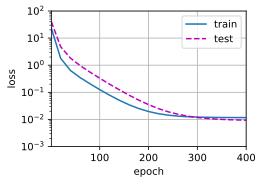

In [46]:
# 三阶多项式函数拟合(正态)
# 使用前4个特征（对应1, x, x^2/2!, x^3/3!）
# poly_features -> (200, 20)
train(
    poly_features[:n_train, :4],  # 提取前100行, 前4列作为训练输入数据
    poly_features[n_train:, :4],  # 提取后100行, 前4列作为测试输入数据
    labels[:n_train],  # 提取前100行作为训练标签
    labels[n_train:]   # 提取后100行作为测试标签 
)

weight: [[3.6402385 3.5488133]]


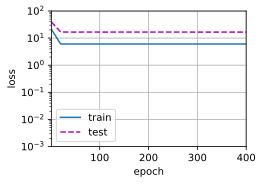

In [47]:
# 线性函数拟合(欠拟合)
# 只使用前2个特征（1, x）
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:])

weight: [[ 4.9950275   1.2923028  -3.362204    5.1414356  -0.148607    1.3645214
   0.21762915  0.07396004  0.00783006  0.06859261  0.10738154  0.07681762
  -0.07702757 -0.0959843  -0.09656693  0.15663509  0.21409786 -0.05755375
   0.03401777 -0.09954283]]


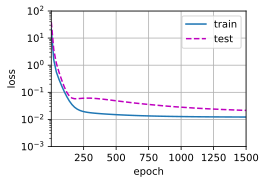

In [48]:
# 高阶多项式函数拟合(过拟合)
# 使用所有20个多项式特征
train(poly_features[:n_train, :], poly_features[n_train:, :],
     labels[:n_train], labels[n_train:], num_epochs=1500)